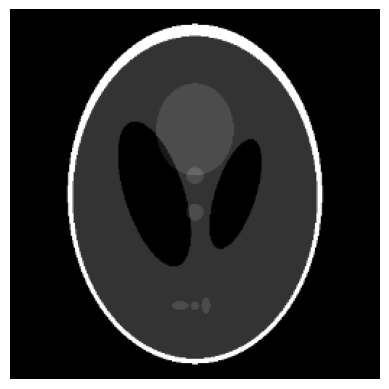

In [1]:
from datasets import Phantom
from matplotlib import pyplot as plt

dataset = Phantom(image_size = (256,256))

phantom = dataset[0]

def imshow(data):
    plt.figure()
    plt.imshow(data[0], cmap = 'gray')
    plt.axis('off')
    plt.show()

imshow(phantom)

In [2]:
import torch
import torch.nn.functional as F

# 假设一个简单的 2D 图像张量（1x1xH x W 格式，单通道）
image = torch.tensor([[1.0, 2.0, 3.0],
                      [4.0, 5.0, 6.0],
                      [7.0, 8.0, 9.0]]).unsqueeze(0).unsqueeze(0)  # Shape: (1, 1, 3, 3)

# 查询的连续坐标 (x, y)，注意：坐标需要在 [-1, 1] 范围内
# 例如，中心为 (0, 0)，左上角为 (-1, -1)，右下角为 (1, 1)
coords = torch.tensor([[[[0.0, 0.0]],  # 中心位置
                        [[-0.5, -0.5]],  # 接近左上角
                        [[0.3, 0.3]]]])  # 接近右下角  Shape: (1, N, 2)

# 使用 grid_sample 进行插值
# align_corners=True 确保坐标与像素对齐
interpolated_values = F.grid_sample(image, coords, mode='bilinear', align_corners=True)

# 打印结果
print(interpolated_values)

tensor([[[[5.0000],
          [3.0000],
          [6.2000]]]])


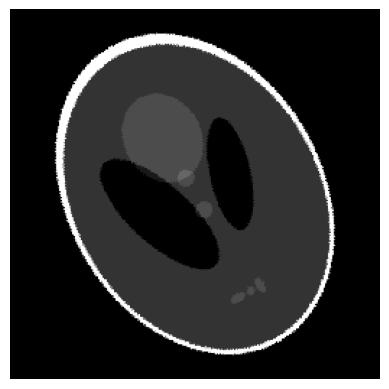

In [3]:
from torchvision.transforms.functional import rotate

angle = 30

phantom_rotate = rotate(phantom, angle)

imshow(phantom_rotate)

tensor(4.1950) tensor(-0.5889)
torch.Size([1, 1, 256, 256])
torch.Size([1, 1, 256, 256])
torch.Size([1, 256, 256, 2])


/home/lyy/miniconda3/envs/moco/lib/python3.10/site-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647382455/work/aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Loss: 4551.58740234375
Loss: 2.596712112426758
Loss: 1.953747034072876
Loss: 1.6987954378128052
Loss: 1.6853761672973633
Loss: 1.6712398529052734
Loss: 1.4154770374298096
Loss: 1.3778183460235596
Loss: 1.4157615900039673
Loss: 1.2697398662567139
Loss: 1.2813658714294434
Loss: 1.2226638793945312
Loss: 1.2011849880218506
Loss: 1.1873304843902588
Loss: 1.1710584163665771
Loss: 1.16941499710083
Loss: 1.1705204248428345
Loss: 1.1465131044387817
Loss: 1.1976521015167236
Loss: 1.1260790824890137
Loss: 1.1152777671813965
Loss: 1.0965298414230347
Loss: 1.0893008708953857
Loss: 1.1176719665527344
Loss: 1.0760599374771118
Loss: 1.0664368867874146
Loss: 1.0598938465118408
Loss: 1.055389404296875
Loss: 1.0522823333740234
Loss: 1.0502939224243164
Loss: 1.0401115417480469
Loss: 1.0308197736740112
Loss: 1.0338561534881592
Loss: 1.0378191471099854
Loss: 1.0313398838043213
Loss: 1.0267293453216553
Loss: 1.015568733215332
Loss: 1.0210044384002686
Loss: 1.0071678161621094
Loss: 1.0117051601409912
Loss: 0.

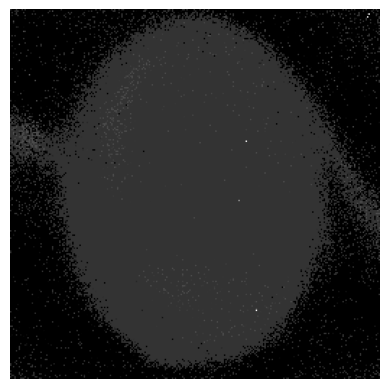

In [4]:
from torch import nn

# 建立坐标到坐标的映射
class INR(nn.Module):
    def __init__(self, d_model):
        super(INR, self).__init__()
        self.input_embedding = nn.Linear(2, d_model)
        self.inr = nn.TransformerEncoderLayer(d_model=d_model, nhead=8)
        self.output_embedding = nn.Linear(d_model, 2)

        # self.inr = nn.Sequential(
        #     nn.Linear(d_model, d_model),
        #     nn.ReLU(),
        #     nn.Linear(d_model, d_model),
        #     nn.ReLU(),
        #     nn.Linear(d_model, d_model),
        # )

        # self.clamp = nn.Tanh() # -1~1


    def forward(self, x):
        diff = x.view(1, 256 * 256, 2)
        diff = self.input_embedding(diff)
        diff = self.inr(diff)
        diff = self.output_embedding(diff)
        diff = diff.view(1, 256, 256, 2)
        # x = self.clamp(x)
        x = x + diff
        return x
    

x = phantom_rotate.unsqueeze(0)
true = phantom.unsqueeze(0)

x = (x - x.mean())/x.std()
true = (true - true.mean())/true.std()

print(x.max(), x.min())

print(x.shape)
print(true.shape)

def loss_fn(pred, true):
    return nn.functional.mse_loss(pred, true)

# 构造256 * 256的坐标矩阵
x_coords = torch.linspace(-1, 1, 256) 
y_coords = torch.linspace(-1, 1, 256)
grid = torch.stack(torch.meshgrid(x_coords, y_coords), dim=-1)
grid = grid.unsqueeze(0).float()
print(grid.shape)

# grid = torch.randn(1,256,256,2) * 0.1

# 初始化模型
model = INR(d_model = 128)

# 优化器
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

# 训练
for i in range(10000):
    optimizer.zero_grad()
    pos_pred = model(grid)
    constraint_loss = torch.sum(torch.relu(pos_pred - 1) + torch.relu(-pos_pred - 1))
    pred = F.grid_sample(x, pos_pred, mode='bilinear', align_corners=True)
    loss = loss_fn(pred, true) + constraint_loss
    loss.backward()
    optimizer.step()
    if i % 100 == 0:
        print(f'Loss: {loss.item()}')


pred = (pred - pred.min()) / (pred.max() - pred.min())

imshow(pred[0].detach().numpy())

In [5]:
print(pred.max(), pred.min())

tensor(1., grad_fn=<MaxBackward1>) tensor(0., grad_fn=<MinBackward1>)
